In [130]:
# Load packages
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [131]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/intermediate/call_reports_SP/'

# Set path to be the directory:
os.chdir(path)

In [132]:
#df = pd.concat([pd.read_csv(f) for f in os.listdir() if f.endswith('.csv')])
#df = df.iloc[:, 0:270]
#df['Date'] = df['Date'].astype(str)
#df['Month'] = np.where(df['Date'].str.len() == 8, df['Date'].str[0:2], '0'+df['Date'].str[0])
#df['Day'] = df['Date'].str[-6:-4]
#df['Year'] = df['Date'].str[-4:]
#df['Date'] = pd.to_datetime(df['Year'] + '-' + df['Month'] + '-' + df['Day'])
#df.to_csv(path + 'call_reports.csv', index = False)

In [133]:
# Read file that contains only the variables of interest, specify that the column 'Date' is a date:
df = pd.read_csv('call_reports.csv', parse_dates = ['Date'])

C:\Users\angel\AppData\Local\Temp\ipykernel_23800\1849562282.py:2: DtypeWarning: Columns (102,146,187,228) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('call_reports.csv', parse_dates = ['Date'])


In [134]:
# create a 'Year' variable:
df['Year'] = df['Date'].dt.year

### Deposits

In [135]:
# Create a new column that will contain the deposit expenditure it will sum 'RIADA517', 'RIADA518', 'RIAD4508', 'RIAD0093' for
# any date before 2017:
df['Deposit Expenditure'] = np.where(df['Date'] < '2017-01-01', df['RIADA517']+df['RIADA518']+df['RIAD4508']+df['RIAD0093'], 
                                     df['RIADHK03']+df['RIADHK04']+df['RIAD4508']+df['RIAD0093'])

In [136]:
# Group by 'ID' and compute the difference in 'Deposit_Expenditure' to get the actual expenditure per period
df['Actual Expenditure'] = df.groupby(['IDRSSD', 'Year'])['Deposit Expenditure'].diff().fillna(df['Deposit Expenditure'])

In [137]:
df['Total Deposit'] = np.where(df['Date'] < '2017-01-01', df['RCON3485']+df['RCONB563']+df['RCONA514']+df['RCONA529'], 
                                     df['RCON3485']+df['RCONB563']+df['RCONHK16']+df['RCONHK17'])

In [138]:
df = df[df['Total Deposit']>0]

In [139]:
df['Deposit Rate'] = df['Actual Expenditure'] / df['Total Deposit']

In [140]:
# Average the deposit rate by 'Date', weighting by 'Total Deposit':
df['Weighted Deposit Rate'] = df.groupby('Date')['Deposit Rate'].transform(lambda x: np.average(x, weights = df.loc[x.index, 'Total Deposit']))

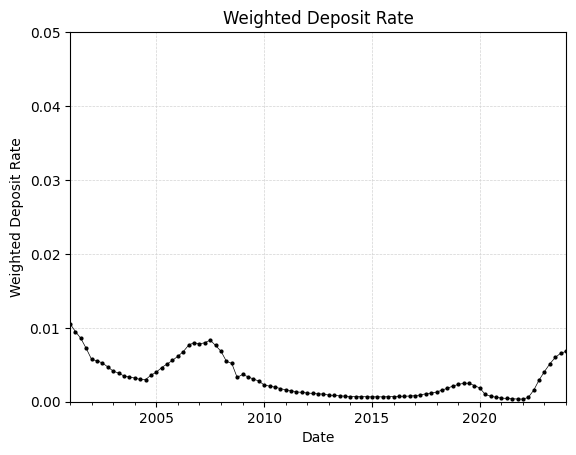

In [141]:
# plot the weighted deposit rate by date in a way we have only one observation per date:
df[['Date', 'Weighted Deposit Rate']].sort_values('Date').drop_duplicates('Date').set_index('Date').plot(marker='o', color='black', markersize=2, linewidth=0.5)
plt.ylim(0, 0.05)
plt.xlabel('Date')
plt.ylabel('Weighted Deposit Rate')
plt.title('Weighted Deposit Rate')
plt.legend().remove()
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
plt.show()


In [142]:
# Create an extra column in df3 with the avg. deposit rate per Date:
df['Avg. Deposit Rate'] = df.groupby('Date')['Deposit Rate'].transform('mean')
df['Std. Deposit Rate'] = df.groupby('Date')['Deposit Rate'].transform('std')

In [143]:
df['R_hat'] = (df['Deposit Rate'] - df['Avg. Deposit Rate']) / df['Std. Deposit Rate']

In [144]:
# Until here, dataset matches with Lucas.
#df2[(df2['Date']>'2023-01-01') & (df2['Date']<'2024-01-01')]['Deposit Rate'].describe()

##### Distribution of deposit rates

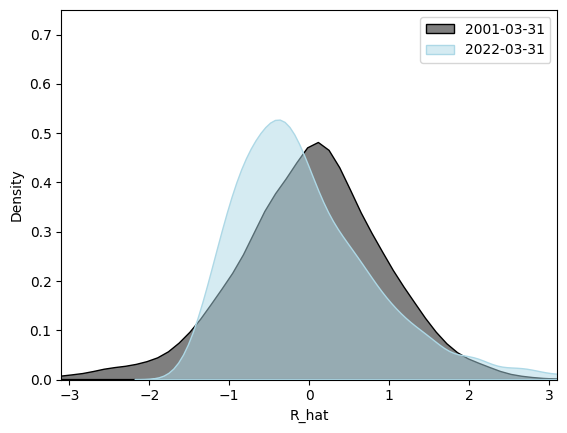

In [145]:
# plot the kernel distribution of the deposit rates for the above dates:
sns.kdeplot(df[df['Date']=='2001-03-31']['R_hat'], label='2001-03-31', color='black', fill=True, alpha=0.5)
sns.kdeplot(df[df['Date']=='2022-03-31']['R_hat'], label='2022-03-31', color='lightblue', fill=True, alpha=0.5)
plt.xlim(-3.1, 3.1)
plt.ylim(0, 0.75)
plt.legend()
plt.show()

C:\Users\angel\AppData\Local\Temp\ipykernel_23800\3112216600.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_bottom = df.groupby('Date').apply(lambda x: x[(x['Total Deposit'] >= x['Total Deposit'].quantile(0.05))&
C:\Users\angel\AppData\Local\Temp\ipykernel_23800\3112216600.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top = df.groupby('Date').apply(lambda x: x[x['Total Deposit'] >= x['Total

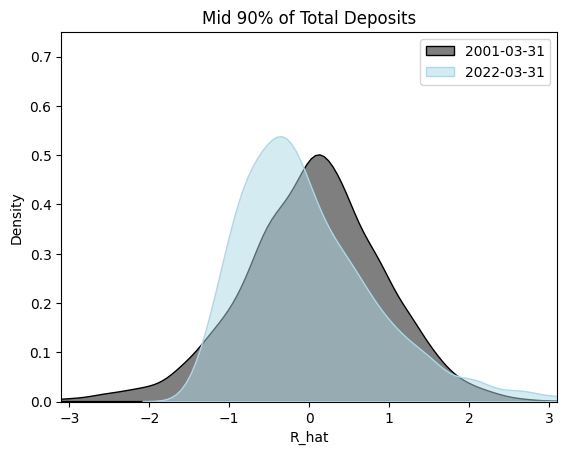

In [146]:
df_bottom = df.groupby('Date').apply(lambda x: x[(x['Total Deposit'] >= x['Total Deposit'].quantile(0.05))&
                                                 (x['Total Deposit'] <= x['Total Deposit'].quantile(0.95))]).reset_index(drop=True)
df_top = df.groupby('Date').apply(lambda x: x[x['Total Deposit'] >= x['Total Deposit'].quantile(0.95)]).reset_index(drop=True)


# plot the kernel distribution of the deposit rates for the above dates:
sns.kdeplot(df_bottom[df_bottom['Date']=='2001-03-31']['R_hat'], label='2001-03-31', color='black', fill=True, alpha=0.5)
sns.kdeplot(df_bottom[df_bottom['Date']=='2022-03-31']['R_hat'], label='2022-03-31', color='lightblue', fill=True, alpha=0.5)
#Adjust the x-axis to be able to see the distribution better:
plt.xlim(-3.1, 3.1)
plt.ylim(0, 0.75)
plt.legend()
plt.title('Mid 90% of Total Deposits')
plt.savefig('mid_90.svg')
plt.show()


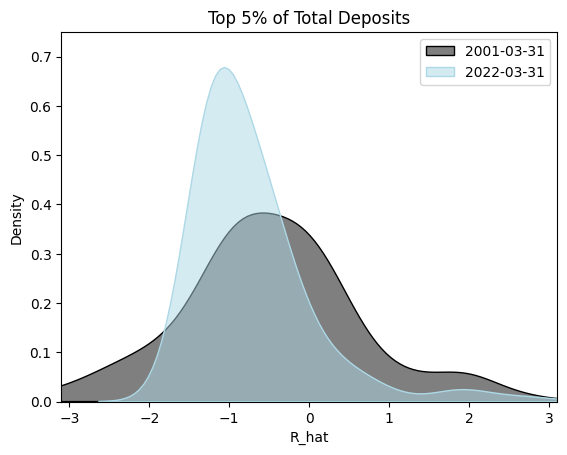

In [147]:
# plot the kernel distribution of the deposit rates for the above dates:
sns.kdeplot(df_top[df_top['Date']=='2001-03-31']['R_hat'], label='2001-03-31', color='black', fill=True, alpha=0.5)
sns.kdeplot(df_top[df_top['Date']=='2022-03-31']['R_hat'], label='2022-03-31', color='lightblue', fill=True, alpha=0.5)
plt.xlim(-3.1, 3.1)
plt.ylim(0, 0.75)
plt.legend()
plt.title('Top 5% of Total Deposits')
plt.savefig('top_5.svg')
plt.show()




##### Where does this dispersion is coming from?

In [148]:
# Rename RCONB563 as 'Savings Accounts':
df.rename(columns = {'RCONB563':'Savings Accounts', 'RCON3485': 'Transaction Accounts'}, inplace = True)

In [149]:
df['Small TD'] = np.where(df['Date'] < '2017-01-01', df['RCONA529'], df['RCONHK16']) 
df['Small TD Exp'] = np.where(df['Date'] < '2017-01-01', df['RIADA518'], df['RIADHK03'])
df['Large TD'] = np.where(df['Date'] < '2017-01-01', df['RCONA514'], df['RCONHK17']) 
df['Large TD Exp'] = np.where(df['Date'] < '2017-01-01', df['RIADA517'], df['RIADHK04'])

In [150]:
df['Actual Small TD Exp'] = df.groupby(['IDRSSD', 'Year'])['Small TD Exp'].diff().fillna(df['Small TD Exp'])
df['Actual Large TD Exp'] = df.groupby(['IDRSSD', 'Year'])['Large TD Exp'].diff().fillna(df['Large TD Exp'])

In [151]:
df['Savings Rate'] = df.groupby(['IDRSSD', 'Year'])['RIAD0093'].diff().fillna(df['RIAD0093']) / df['Savings Accounts']
df['Large TD Rate'] = df['Actual Large TD Exp'] / df['Large TD']
df['Small TD Rate'] =   df['Actual Small TD Exp'] / df['Small TD']

In [152]:
# Create a new column that contains the share of each type of deposit in the total deposits, per year, per bank:
df['Small TD Share'] = df['Small TD'] / df['Total Deposit']
df['Large TD Share'] = df['Large TD'] / df['Total Deposit']
df['Savings Share'] = df['Savings Accounts'] / df['Total Deposit']
df['Transaction Share'] = df['Transaction Accounts'] / df['Total Deposit']


In [165]:
# take the top 10 banks in 'Total Deposit' in the most recent date, and plot their deposit rates:
top_10_today = df[df['Date'] == df['Date'].max()].nlargest(10, 'Total Deposit')['Financial Institution Name']

In [154]:
df['Savings Rate'] = df['Savings Rate']*100

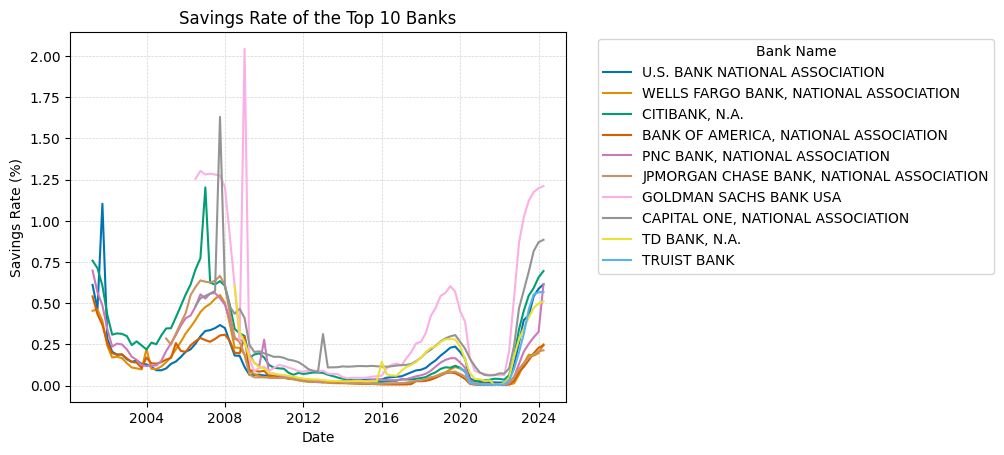

In [167]:
# use 'bank_data' to plot the time series of savings rates, dont use red or green colors:
sns.lineplot(data = df[df['Financial Institution Name'].isin(top_10_today)], x = 'Date', y = 'Savings Rate', hue = 'Financial Institution Name', palette = 'colorblind')
plt.xlabel('Date')
plt.ylabel('Savings Rate (%)')
plt.title('Savings Rate of the Top 10 Banks')
plt.legend(title = 'Bank Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
plt.savefig('savings_rate.svg')
plt.show()

In [156]:
# make a dataset that has only the top 10 banks in 'Total Deposit' per year:
df_top10 = df.groupby(['Date']).apply(lambda x: x.nlargest(10, 'Total Deposit')).reset_index(drop=True)

# compute the share of each bank in the total deposits of the top 10 banks per year:
df_top10['Share in Top 10'] = df_top10['Total Deposit'] / df_top10.groupby('Date')['Total Deposit'].transform('sum')

C:\Users\angel\AppData\Local\Temp\ipykernel_23800\527871687.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top10 = df.groupby(['Date']).apply(lambda x: x.nlargest(10, 'Total Deposit')).reset_index(drop=True)


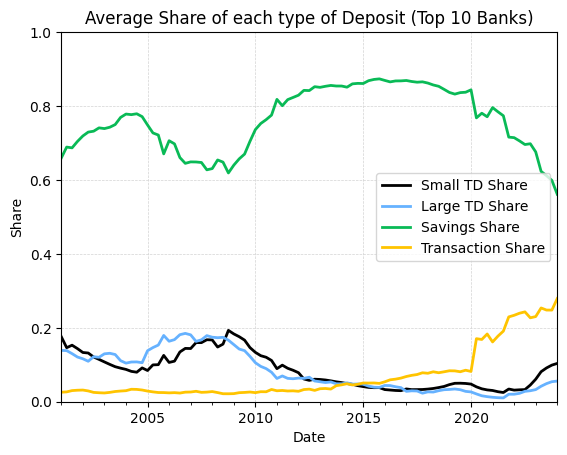

In [157]:
# Group by 'Date' and sum the weighted shares:
df_top10_unweighted_shares = df_top10.groupby('Date')[['Small TD Share', 'Large TD Share', 
                                    'Savings Share', 'Transaction Share']].mean().reset_index()

# plot the weighted average share of each type of deposit for the top 10 banks:
df_top10_unweighted_shares.set_index('Date').plot(markersize=2, linewidth=2, 
                                color=['black', '#66B2FF', '#09BA56', '#FFC400'])
plt.xlabel('Date')
plt.ylabel('Share')
plt.ylim(0, 1)
plt.title('Average Share of each type of Deposit (Top 10 Banks)')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
plt.savefig('top_10_shares.svg')
plt.show()


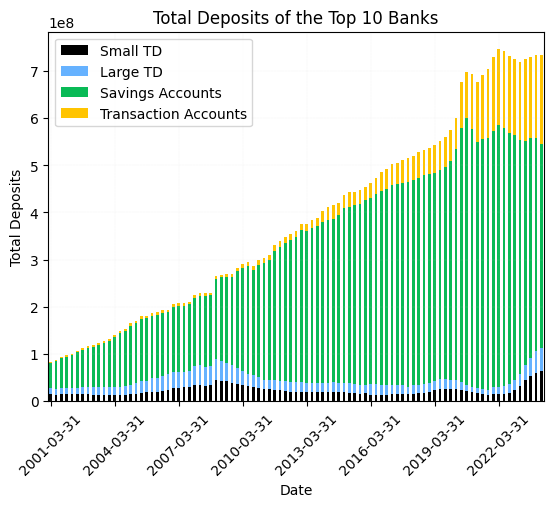

In [158]:
df_top10_unweighted = df_top10.groupby('Date')[['Small TD', 'Large TD', 
                                    'Savings Accounts', 'Transaction Accounts']].mean().reset_index()

# make a stacked bar plot of the total deposits of the top 10 banks:
df_top10_unweighted.set_index('Date').plot(kind='bar', stacked=True, color=['black', '#66B2FF', '#09BA56', '#FFC400'])
# add just some ticks in the x-axis in the format 'YYYY-MM-DD':
plt.xticks(np.arange(0, len(df_top10_unweighted), 12), df_top10_unweighted['Date'].dt.strftime('%Y-%m-%d')[::12], rotation=45)
plt.xlabel('Date')
plt.ylabel('Total Deposits')
plt.title('Total Deposits of the Top 10 Banks')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.1)
plt.show()



In [159]:
# compute the weighted average of the share of each type of deposit for the top 10 banks, weighted by 'Share in Top 10':
df_top10['Weighted Small TD Share'] = df_top10['Small TD Share'] * df_top10['Share in Top 10']
df_top10['Weighted Large TD Share'] = df_top10['Large TD Share'] * df_top10['Share in Top 10']
df_top10['Weighted Savings Share'] = df_top10['Savings Share'] * df_top10['Share in Top 10']
df_top10['Weighted Transaction Share'] = df_top10['Transaction Share'] * df_top10['Share in Top 10']

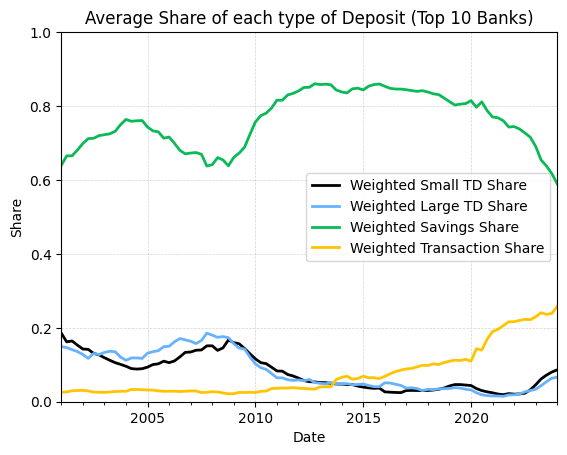

In [160]:
# Group by 'Date' and sum the weighted shares:
df_top10_weighted = df_top10.groupby('Date')[['Weighted Small TD Share', 'Weighted Large TD Share', 
                                    'Weighted Savings Share', 'Weighted Transaction Share']].sum().reset_index()

# plot the weighted average share of each type of deposit for the top 10 banks:
df_top10_weighted.set_index('Date').plot(markersize=2, linewidth=2, 
                                color=['black', '#66B2FF', '#09BA56', '#FFC400'])
plt.xlabel('Date')
plt.ylabel('Share')
plt.ylim(0, 1)
plt.title('Average Share of each type of Deposit (Top 10 Banks)')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
plt.show()

In [161]:
# Do the same for the bottom 80 percentile of banks in 'Total Deposit', use the 'quantile' method to get the 80th percentile:
df_bottom80 = df.groupby(['Date']).apply(lambda x: x[x['Total Deposit'] <= x['Total Deposit'].quantile(0.80)]).reset_index(drop=True)


C:\Users\angel\AppData\Local\Temp\ipykernel_23800\2923166472.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_bottom80 = df.groupby(['Date']).apply(lambda x: x[x['Total Deposit'] <= x['Total Deposit'].quantile(0.80)]).reset_index(drop=True)


In [162]:
# for each year, plot the average share of each type of deposit:
#df_bottom80[['Date', 'Small TD Share', 'Large TD Share', 'Savings Share', 'Transaction Share']].groupby('Date').mean().plot(linewidth=2)
#plt.xlabel('Date')
#plt.ylabel('Share')
#plt.ylim(0, 1)
#plt.title('Average Share of each type of Deposit (Bottom 80% of Banks)')
#plt.legend(title='Deposit Type')
#plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
#plt.show()

In [163]:
# Create an extra column in df3 with the avg. deposit rate per Date:
df2 = df[(df['RCONB563']>0) & (df['Insured TD']>0) & (df['Large TD']>0)].copy()

KeyError: 'RCONB563'

In [ ]:
df2['Avg. Savings Rate'] = df2.groupby('Date')['Savings Rate'].transform('mean')
df2['Std. Savings Rate'] = df2.groupby('Date')['Savings Rate'].transform('std')
df2['Savings_hat'] = (df2['Savings Rate'] - df2['Avg. Savings Rate']) #/ df2['Std. Savings Rate']

In [ ]:
df3 = df[(df['RCONB563']>0) & (df['Insured TD']>0) & (df['Large TD']>0)].copy()
df3 = df3.groupby('Year').apply(lambda x: x[(x['Insured TD'] >= x['Insured TD'].quantile(0.01)) & (x['Insured TD'] <= x['Insured TD'].quantile(0.99))]).reset_index(drop=True)

In [ ]:
df3['Avg. Insured TD Rate'] = df3.groupby('Date')['Insured TD Rate'].transform('mean')
df3['Std. Insured TD Rate'] = df3.groupby('Date')['Insured TD Rate'].transform('std')
df3['Insured_TD_hat'] = (df3['Insured TD Rate'] - df3['Avg. Insured TD Rate']) #/ df3['Std. Small TD Rate']